# CNN Training

In [11]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

## Checking if GPU is available

In [12]:
tf.config.experimental.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

In [13]:
DATA_DIR = os.path.join("data")

DATA_WITH_OUTLIERS_PATH = os.path.join(
    DATA_DIR, "balance_sheets_quarterly_processed.csv"
)
DATA_WITHOUT_OUTLIERS_PATH = os.path.join(
    DATA_DIR, "balance_sheets_quarterly_no_outliers.csv"
)

MODEL_WITH_OUTLIERS_NAME = "model_with_outliers"
MODEL_WITHOUT_OUTLIERS_NAME = "model_without_outliers"

## Creating and training a CNN model

### Use early stopping to stop training when results do not improve

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,  # Restores the weights from the epoch with the best validation loss
)

### Helper functions

In [15]:
def prepare_data(data_path):
    df = pd.read_csv(data_path)
    df = df.drop(columns=["symbol", "date"])

    X = df.drop(columns=["marketCap"])
    y = df["marketCap"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, X_test, y_train, y_test


def create_model(X_train):
    model = models.Sequential(
        [
            layers.Input(shape=(X_train.shape[1], 1)),
            layers.Conv1D(64, kernel_size=2, activation="relu"),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(128, kernel_size=2, activation="relu"),
            layers.Conv1D(256, kernel_size=2, activation="relu"),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mae"],
    )

    return model


def load_or_train_model(data_path, model_name):
    try:
        model = models.load_model(os.path.join("models", model_name + ".keras"))
        history = pd.read_csv(os.path.join("history", model_name + ".csv"))
        return model, history
    except (FileNotFoundError, ValueError):
        X_train, X_test, y_train, y_test = prepare_data(data_path)
        model = create_model(X_train)
        results = model.fit(
            X_train,
            y_train,
            epochs=200,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
        )

        models_dir = os.path.join("models")
        os.makedirs(models_dir, exist_ok=True)
        model.save(os.path.join(models_dir, model_name + ".keras"))

        history_dir = os.path.join("history")
        os.makedirs(history_dir, exist_ok=True)

        history_df = pd.DataFrame(results.history)
        history_df.to_csv(os.path.join(history_dir, model_name + ".csv"), index=False)

        return model, history_df

### Training the model

#### Model for data with outliers

In [16]:
with_outliers_model, with_outliers_history = load_or_train_model(
    DATA_WITH_OUTLIERS_PATH, MODEL_WITH_OUTLIERS_NAME
)

Epoch 1/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6240 - mae: 0.1898 - val_loss: 1.1116 - val_mae: 0.1933
Epoch 2/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4011 - mae: 0.1501 - val_loss: 0.7561 - val_mae: 0.1415
Epoch 3/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2195 - mae: 0.1227 - val_loss: 0.5490 - val_mae: 0.1338
Epoch 4/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2959 - mae: 0.1352 - val_loss: 0.5429 - val_mae: 0.1308
Epoch 5/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1516 - mae: 0.1126 - val_loss: 0.5819 - val_mae: 0.1295
Epoch 6/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1725 - mae: 0.1031 - val_loss: 0.5392 - val_mae: 0.1380
Epoch 7/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1984 - mae: 0.1078 - val_loss: 0.4354 - val_mae: 0.0904
Epoch 8/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2383 - mae: 0.1072 - val_loss: 0.4345 - val_mae: 0.0911
Epoch 9/200
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

#### Model for data without outliers

In [17]:
without_outliers_model, without_outliers_history = load_or_train_model(
    DATA_WITHOUT_OUTLIERS_PATH, MODEL_WITHOUT_OUTLIERS_NAME
)

Epoch 1/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5110 - mae: 0.1864 - val_loss: 0.5338 - val_mae: 0.1821
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3184 - mae: 0.1498 - val_loss: 0.2399 - val_mae: 0.1192
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1917 - mae: 0.1199 - val_loss: 0.2113 - val_mae: 0.1287
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1482 - mae: 0.1047 - val_loss: 0.1684 - val_mae: 0.1101
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1758 - mae: 0.1212 - val_loss: 0.2273 - val_mae: 0.1293
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1350 - mae: 0.1062 - val_loss: 0.1247 - val_mae: 0.0907
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0968 - mae: 0.0872 - val_loss: 0.1109 - val_mae: 0.1037
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0879 - mae: 0.0871 - val_loss: 0.0914 - val_mae: 0.0824
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

## Training results

### Helper functions

In [18]:
def evaluate_model(model, data_path):
    X_train, X_test, y_train, y_test = prepare_data(data_path)
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Loss: {loss}, MAE: {mae}")

def plot_training_history(history):
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Loss History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(history["mae"], label="Train MAE")
    plt.plot(history["val_mae"], label="Validation MAE")
    plt.title("MAE History")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Absolute Error")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Results

#### For model trained on data with outliers

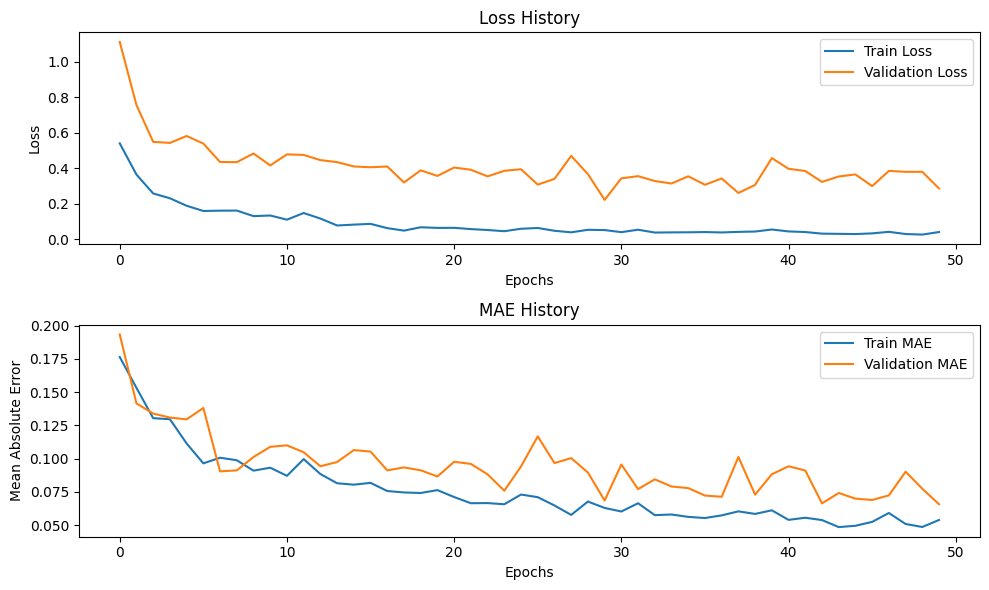

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0832 - mae: 0.0577
Loss: 0.22205325961112976, MAE: 0.06843137741088867


In [19]:
plot_training_history(with_outliers_history)
evaluate_model(with_outliers_model, DATA_WITH_OUTLIERS_PATH)

#### For model trained on data without outliers

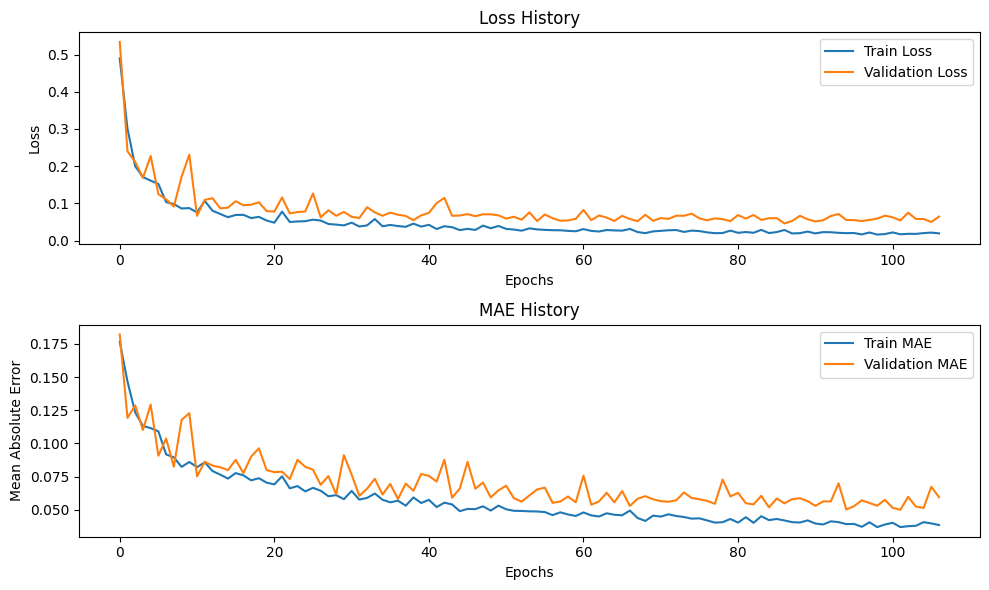

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0523 - mae: 0.0540
Loss: 0.04597578942775726, MAE: 0.05481503903865814


In [20]:
plot_training_history(without_outliers_history)
evaluate_model(without_outliers_model, DATA_WITHOUT_OUTLIERS_PATH)